## Description：
这个jupyter是FiBiNet模型的demo， 主要包括读取数据， 搭建模型，模型训练和评估三大部分。

In [16]:
# python基础包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from utils import DenseFeat, SparseFeat, VarLenSparseFeat

# 导入模型
from FiBinet import fibinet
#from deepctr.models.fibinet import FiBiNET

#from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from utils import DenseFeat, SparseFeat, VarLenSparseFeat

# 模型训练相关
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# 一些相关设置
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## 导入数据与初步处理

In [2]:
# 简单处理特征， 包括填充缺失值，数值处理， 类别编码
def data_process(data_df, dense_features, sparse_features):
    # 连续型特征用0填充缺失, 并进行对数转换
    data_df[dense_features] = data_df[dense_features].fillna(0.0)
    for f in dense_features:
        data_df[f] = data_df[f].apply(lambda x: np.log(x+1) if x > -1 else -1)
    
    # 离散型特征用-1填充，并进行LabelEncoder编码
    data_df[sparse_features] = data_df[sparse_features].fillna("-1")
    for f in sparse_features:
        lbe = LabelEncoder()
        data_df[f] = lbe.fit_transform(data_df[f])
    
    return data_df[dense_features+sparse_features]

In [3]:
"""读取数据"""
data = pd.read_csv('data/criteo_sample.txt')

In [4]:
"""划分dense和sparse特征"""
columns = data.columns.values
dense_features = [feat for feat in columns if 'I' in feat]
sparse_features = [feat for feat in columns if 'C' in feat]

In [5]:
"""简单的数据预处理"""
train_data = data_process(data, dense_features, sparse_features)
train_data['label'] = data['label']

In [6]:
"""划分数据集"""
trnx, valx, trny, valy = train_test_split(train_data[dense_features+sparse_features], train_data['label'], test_size=0.1)

In [7]:
"""特征分组， 分成linear部分和DNN部分(根据实际场景进行选择)，并将分组之后的特征用namedtuple封装起来(DenseFeat, SparseFeat)"""
linear_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                         for i, feat in enumerate(sparse_features)] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

dnn_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(), embedding_dim=4)
                         for i, feat in enumerate(sparse_features)] + \
                         [DenseFeat(feat, 1, ) for feat in dense_features]

## 模型建立

In [8]:
"""构建fibinet模型"""
model = fibinet(linear_feature_columns, dnn_feature_columns)
model.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'senet_layer/W_1:0' shape=(26, 8) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
C1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
C3 (InputLayer)     

In [9]:
"""设置超参数"""
learning_rate = 0.001
batch_size = 32
epochs = 50

In [10]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate),
                      metrics=['binary_crossentropy', AUC(name='auc')])

## 模型的训练与评估

In [11]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)
]
#将输入数据转化成字典的形式输入
trnx_model_input = {name: trnx[name] for name in dense_features + sparse_features}
valx_model_input = {name: valx[name] for name in dense_features + sparse_features}

history = model.fit(
                    trnx_model_input, 
                    trny.values,
                    epochs=epochs,
                    callbacks=callbacks,  # checkpoint
                    batch_size=batch_size,
                    validation_split=0.1
                    )

Epoch 1/50
6/6 [==============================] - 39s 2s/step - loss: 5.6903 - binary_crossentropy: 5.6903 - auc: 0.4386 - val_loss: 4.7364 - val_binary_crossentropy: 4.7364 - val_auc: 0.4306
Epoch 2/50
6/6 [==============================] - 1s 86ms/step - loss: 4.0763 - binary_crossentropy: 4.0763 - auc: 0.3470 - val_loss: 3.0879 - val_binary_crossentropy: 3.0879 - val_auc: 0.4514
Epoch 3/50
6/6 [==============================] - 0s 81ms/step - loss: 2.1940 - binary_crossentropy: 2.1940 - auc: 0.4004 - val_loss: 1.2956 - val_binary_crossentropy: 1.2956 - val_auc: 0.4167
Epoch 4/50
6/6 [==============================] - 0s 84ms/step - loss: 1.0358 - binary_crossentropy: 1.0358 - auc: 0.4799 - val_loss: 1.1031 - val_binary_crossentropy: 1.1031 - val_auc: 0.5278
Epoch 5/50
6/6 [==============================] - 0s 82ms/step - loss: 1.2482 - binary_crossentropy: 1.2482 - auc: 0.4717 - val_loss: 1.3867 - val_binary_crossentropy: 1.3867 - val_auc: 0.5000
Epoch 6/50
6/6 [====================

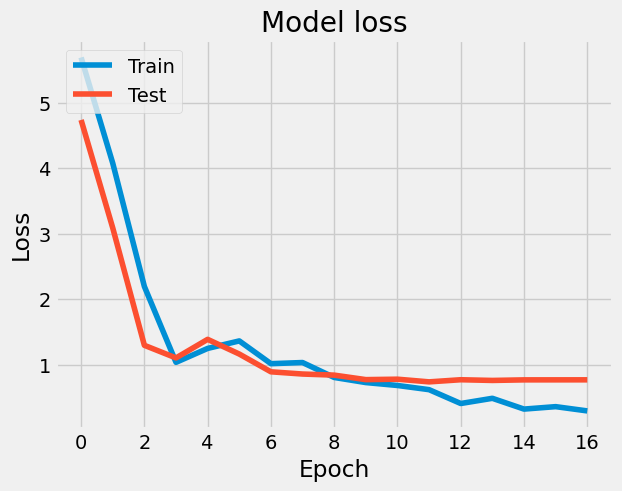

In [12]:
"""可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
"""模型评估"""
print('val AUC: %f' % model.evaluate(valx_model_input, valy, batch_size=batch_size)[1])
print('train AUC: %f' % model.evaluate(trnx_model_input, trny, batch_size=batch_size)[1])

1/1 [==============================] - 0s 65ms/step - loss: 0.8927 - binary_crossentropy: 0.8927 - auc: 0.4286
val AUC: 0.892728
6/6 [==============================] - 0s 42ms/step - loss: 0.4603 - binary_crossentropy: 0.4603 - auc: 0.7860
train AUC: 0.460294


## 模型架构

In [14]:
from tensorflow import keras
keras.utils.plot_model(model, to_file='./fibinet_arc.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]